# ERSST data using xarray

ERSST was the source for global SST data from 1854 to 2024 (approx). 
Then zooming into the North Atlantic region more specifically to plot time series changes in SST. 

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.colors import CenteredNorm
from scipy import stats, signal
from cartopy import crs as ccrs, feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Imports

import xarray as xr

import geoviews as gv
import geoviews.feature as gf

from geoviews import opts
from cartopy import crs

#gv.extension('bokeh', 'matplotlib')

In [2]:
data_url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
sst = xr.open_dataset(data_url).sst
sst

<xarray.DataArray 'sst' (time: 2047, lat: 89, lon: 180)> Size: 131MB
[32792940 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2024-07-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

In [3]:
#access the attributes
attributes = sst.attrs
print("Attributes:", attributes)

Attributes: {'long_name': 'Monthly Means of Sea Surface Temperature', 'units': 'degC', 'var_desc': 'Sea Surface Temperature', 'level_desc': 'Surface', 'statistic': 'Mean', 'dataset': 'NOAA Extended Reconstructed SST V5', 'parent_stat': 'Individual Values', 'actual_range': array([-1.8    , 42.32636], dtype=float32), 'valid_range': array([-1.8, 45. ], dtype=float32), '_ChunkSizes': array([  1,  89, 180], dtype=int32)}


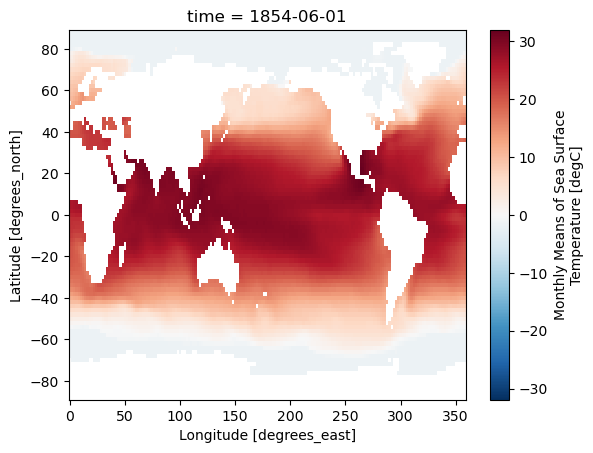

In [4]:
#plot with a single time step
sst.isel(time=5).plot()

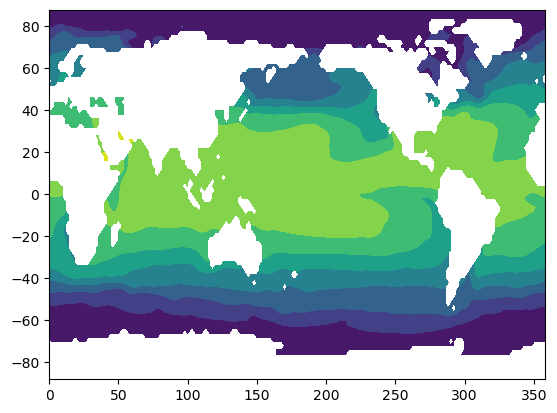

In [5]:
#example contour plot of the global region -- need to narrow to the North Atlantic
plt.contourf(sst.lon,sst.lat,sst.isel(time=30))

In [3]:
# convert lon coordinates from 0:360 to -180:180
sst.coords['lon'] = (sst.coords['lon'] + 180) % 360 - 180
sst = sst.sortby(sst.lon)
sst

<xarray.DataArray 'sst' (time: 2047, lat: 89, lon: 180)> Size: 131MB
[32792940 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * time     (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2024-07-01
  * lon      (lon) float32 720B -180.0 -178.0 -176.0 ... 174.0 176.0 178.0
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

# North Atlantic Region 

Narrowing geographic region and making time series for small time slices

In [4]:
# Select North Atlantic Region
# Note -- Lat [-90:90] Lon [0:360]
na_sst = sst.sel(lon=slice(-98,12), lat=slice(90,0))
na_sst

<xarray.DataArray 'sst' (time: 2047, lat: 45, lon: 56)> Size: 21MB
[5158440 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 180B 88.0 86.0 84.0 82.0 80.0 ... 8.0 6.0 4.0 2.0 0.0
  * time     (time) datetime64[ns] 16kB 1854-01-01 1854-02-01 ... 2024-07-01
  * lon      (lon) float32 224B -98.0 -96.0 -94.0 -92.0 ... 6.0 8.0 10.0 12.0
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

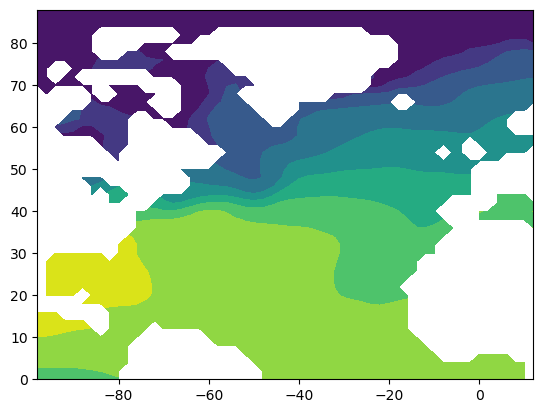

In [8]:
#modified plot just for our region
plt.contourf(na_sst.lon,na_sst.lat,na_sst.isel(time=30))

In [9]:
#single year
na_sst.sel(time='2014')

<xarray.DataArray 'sst' (time: 12, lat: 45, lon: 56)> Size: 121kB
[30240 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 180B 88.0 86.0 84.0 82.0 80.0 ... 8.0 6.0 4.0 2.0 0.0
  * time     (time) datetime64[ns] 96B 2014-01-01 2014-02-01 ... 2014-12-01
  * lon      (lon) float32 224B -98.0 -96.0 -94.0 -92.0 ... 6.0 8.0 10.0 12.0
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

# Averaging 

Global average function used to generate anomaly for North Atlantic data

In [10]:
def global_average(data):
    weights = np.cos(np.deg2rad(data.lat))
    data_weighted = data.weighted(weights)
    return data_weighted.mean(dim=['lat', 'lon'], skipna=True)

In [11]:
# average from 1930 to 1960 (global)

sst_30yr = sst.sel(time=slice('1930','1960'))
sst_30yr

<xarray.DataArray 'sst' (time: 372, lat: 89, lon: 180)> Size: 24MB
[5959440 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * time     (time) datetime64[ns] 3kB 1930-01-01 1930-02-01 ... 1960-12-01
  * lon      (lon) float32 720B -180.0 -178.0 -176.0 ... 174.0 176.0 178.0
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

In [12]:
ga_sst30yr= global_average(sst_30yr).mean(dim='time')
ga_sst30yr

<xarray.DataArray 'sst' ()> Size: 4B
array(17.821074, dtype=float32)

In [ ]:
na_sstannual= na_sst.groupby('time.year').mean().load()

In [13]:
#Averaging in 50 yr time increments

NA_1854_1904 = na_sst.sel(time=slice('1854','1904'))

NA_1905_1954 = na_sst.sel(time=slice('1905','1954'))

NA_1955_2004 = na_sst.sel(time=slice('1955','2004'))

NA_2005_2024 = na_sst.sel(time=slice('2005','2024'))


In [14]:
avg50yr1= global_average(NA_1854_1904)
avg50yr1

KeyboardInterrupt: 

Could not get either of these functions to complete run -- run time was too long

average for North Atlantic: 
NAsst_annual = global_average(na_sst)
NAsst_annual

group_na = na_sst.groupby('time.year').mean()
group_na

# Anomaly calculation

In [ ]:
# North Atlantic Anomaly
# Calculate anomaly by subtracting year's average from all indexes
NAsst_anomaly = NAsst_annual - ga_sst30yr

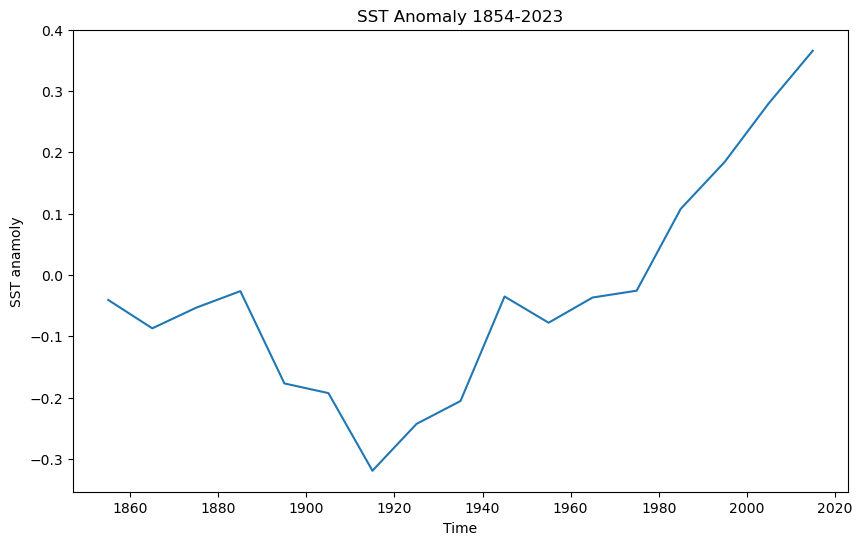

In [30]:
# Select the time slice you want to plot
ds_selected = NAsst_anomaly.sel(time=slice('1854-01', '2023-12'))

# Create a time series plot
fig, ax = plt.subplots(figsize=(10, 6))
ds_selected.mean(dim=['lat', 'lon']).plot(ax=ax)
ax.set_title(f'SST Anomaly 1854-2023')
ax.set_xlabel('Time')
ax.set_ylabel('SST anamoly')
plt.hlines (0,1830,2024)
plt.show()

In [ ]:
ds_selected = na_sst.sel(time=slice('1854-01', '1954-12'))
group_na = ds_selected.groupby('time.year').mean()
group_na

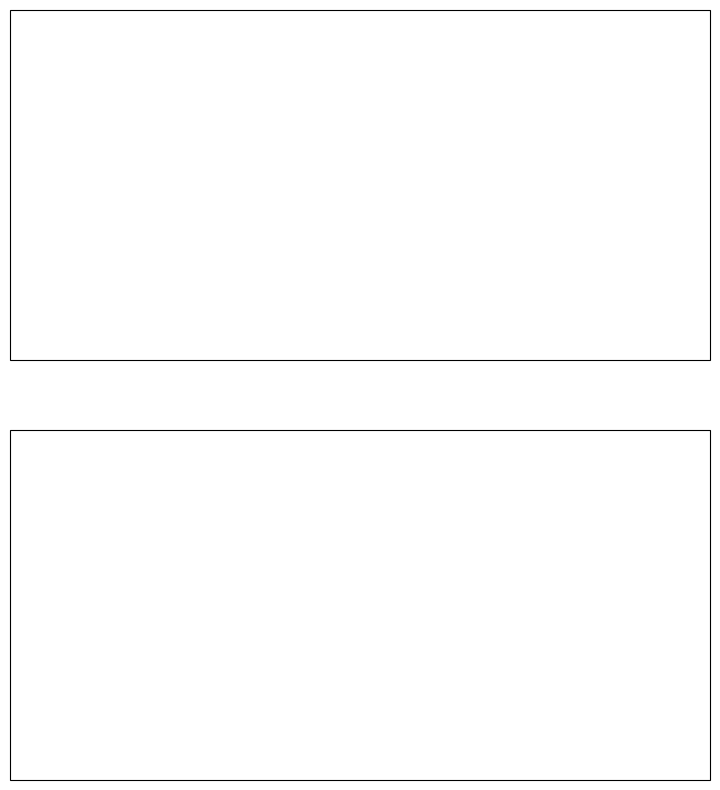

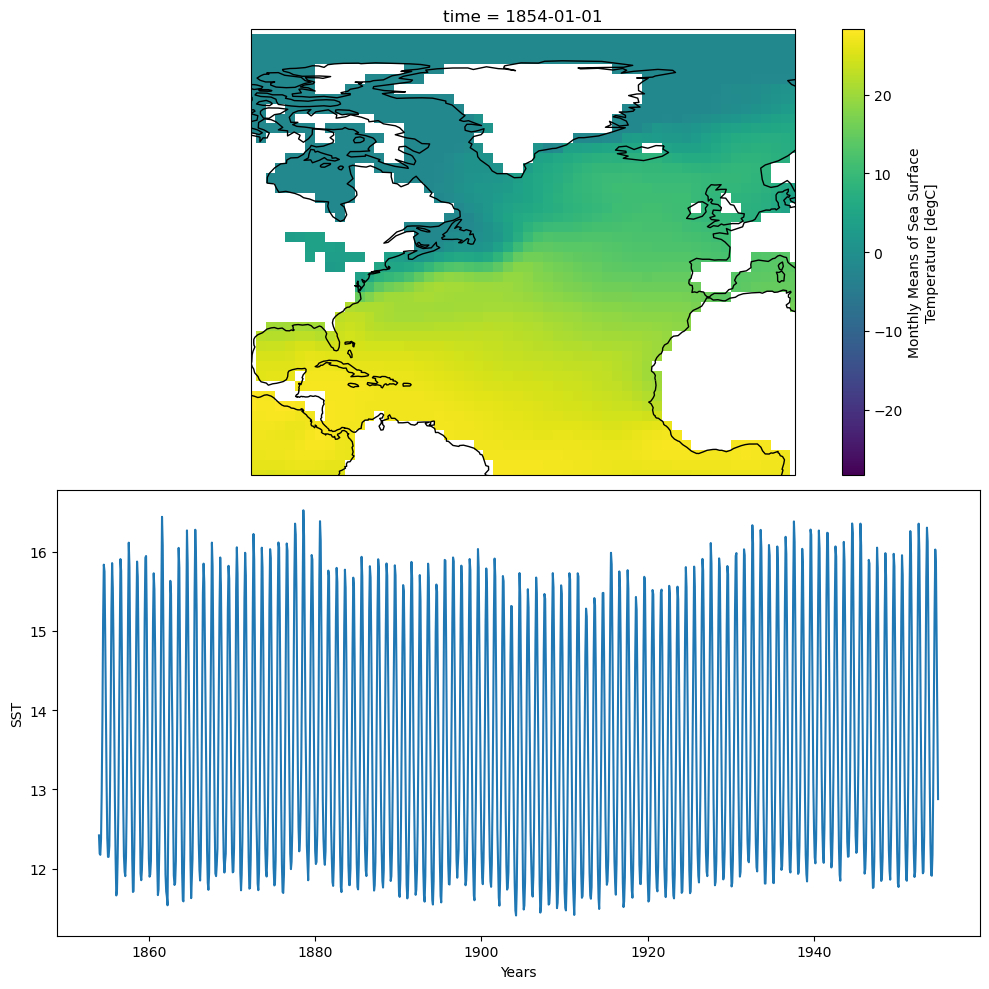

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), 
                               subplot_kw={'projection': ccrs.PlateCarree()}) 
fig = plt.figure(figsize=(10, 10))
ds_selected = na_sst.sel(time=slice('1854-01', '1954-12'))
# Geographic plot
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.set_title('Geographic Plot')
na_sst.isel(time=0).plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='viridis')
ax1.set_extent([-98, 12, 90, 0], crs=ccrs.PlateCarree())
ax1.coastlines()

# Time series plot
ax2 = plt.subplot(2, 1, 2)
ax2.set_title('Time Series Plot')
global_average(ds_selected).plot(ax=ax2)
ax2.set_xlabel('Years')
ax2.set_ylabel('SST')

plt.tight_layout()
plt.show()


In [ ]:

fig = plt.figure(figsize=(10, 10))
ds_selected = na_sst.sel(time=slice('1854-01', '1954-12'))
# Time series plot
ax2 = plt.subplot(2, 1, 2)
ax2.set_title('Time Series Plot')
global_average(ds_selected).plot(ax=ax2)
ax2.set_xlabel('Years')
ax2.set_ylabel('SST')

plt.tight_layout()
plt.show()

In [ ]:
# This will return a subset of the dataset corresponding to the selected date range.
plt.plot(na_sst.sel(time=slice('2022-01-01', '2023-12-31')))